<a href="https://colab.research.google.com/github/iamavailable/Google_Colab_sharing/blob/main/VinBigData_Chest_X_ray_Abnormalities_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
ROOT = "/content/drive/MyDrive/Colab_Notebooks/VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2"
os.chdir(ROOT)

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Colab_Notebooks/VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2'

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!nvidia-smi

Sun Jan 31 16:19:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab_Notebooks/VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2"

In [ ]:
!kaggle datasets download -d xhlulu/vinbigdata

100% 1.94G/1.94G [00:21<00:00, 41.7MB/s]
100% 1.94G/1.94G [00:21<00:00, 98.3MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
!pip install catboost

In [ ]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


# --- setup ---
pd.set_option('max_columns', 50)

In [ ]:
import pickle
from pathlib import Path

import cv2
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path, train: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = imgdir / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

In [ ]:
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content

In [ ]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}

In [ ]:
# --- flags ---
from dataclasses import dataclass
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "/content/drive/MyDrive/Colab_Notebooks/VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2"
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [ ]:
"""
Ref https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=ZyAvNCJMmvFF
"""
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm


setup_logger()


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return COCOEvaluator(dataset_name, cfg, True, output_folder)
        return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

In [ ]:
flags_dict = {
    "debug": True,
    "outdir": "results/debug", 
    "imgdir_name": "VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2",
    "iter": 10000,  # debug, small value should be set.
    "roi_batch_size_per_image": 128  # faster, and good enough for this toy dataset (default: 512)
}

In [ ]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
inputdir = Path("/content/drive/MyDrive/Colab_Notebooks")
datadir = inputdir / "VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train = pd.read_csv(datadir / "train.csv")
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

DatasetCatalog.register(
    "vinbigdata_train1", lambda: get_vinbigdata_dicts(imgdir, train, debug=debug)
)
MetadataCatalog.get("vinbigdata_train1").set(thing_classes=thing_classes)

torch 1.5.0+cu101
flags Flags(debug=True, outdir='results/debug', imgdir_name='VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2', iter=10000, ims_per_batch=2, num_workers=4, base_lr=0.00025, roi_batch_size_per_image=128)


Metadata(name='vinbigdata_train1', thing_classes=['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis'])

In [ ]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)

Load from cache dataset_dicts_cache_debug1.pkl


In [ ]:
anomaly_inds = train.query("class_id != 14").index.values

In [ ]:
anomaly_inds

array([    2,     3,     5, ..., 67907, 67908, 67912])

2


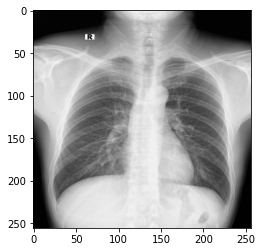

In [ ]:
# Visualize 1 data...
vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train1")
for index, anom_ind in enumerate(anomaly_inds[:1]):
    print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.imwrite(str(outdir / f"vinbigdata{index}.jpg"), out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
d

{'annotations': [],
 'file_name': '/content/drive/MyDrive/Colab_Notebooks/VinBigData-Chest-X-ray-Abnormalities-Detection-Detectron2/train/68335ee73e67706aa59b8b55b54b11a4.png',
 'height': 512,
 'image_id': 2,
 'width': 512}

In [ ]:
cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("vinbigdata_train1",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("vinbigdata_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

cfg.OUTPUT_DIR ./output -> results/debug
[01/31 17:11:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.


[01/31 17:11:23 d2.engine.train_loop]: Starting training from iteration 0
[01/31 17:11:32 d2.utils.events]:  eta: 1:09:36  iter: 19  total_loss: 4.558  loss_cls: 2.995  loss_box_reg: 0.371  loss_rpn_cls: 1.004  loss_rpn_loc: 0.085  time: 0.4146  data_time: 0.0227  lr: 0.000005  max_mem: 1831M
[01/31 17:11:40 d2.utils.events]:  eta: 1:10:35  iter: 39  total_loss: 3.914  loss_cls: 2.784  loss_box_reg: 0.435  loss_rpn_cls: 0.658  loss_rpn_loc: 0.064  time: 0.4225  data_time: 0.0058  lr: 0.000010  max_mem: 1831M
[01/31 17:11:49 d2.utils.events]:  eta: 1:10:02  iter: 59  total_loss: 3.640  loss_cls: 2.477  loss_box_reg: 0.525  loss_rpn_cls: 0.536  loss_rpn_loc: 0.070  time: 0.4192  data_time: 0.0052  lr: 0.000015  max_mem: 1831M
[01/31 17:11:57 d2.utils.events]:  eta: 1:09:40  iter: 79  total_loss: 3.086  loss_cls: 2.107  loss_box_reg: 0.544  loss_rpn_cls: 0.304  loss_rpn_loc: 0.061  time: 0.4185  data_time: 0.0055  lr: 0.000020  max_mem: 1831M
[01/31 17:12:05 d2.utils.events]:  eta: 1:08:5